# To run if on Colab

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import shutil
import zipfile
import os

file_name = 'Dataset_TXA.zip'

# copying the dataset to the temporary workspace
print('Copying Dataset to temporary workspace...')
shutil.copyfile('drive/MyDrive/Dataset_TXA.zip', 'Dataset_TXA.zip')
print('Copied...')

# unzipping the dataset
path = 'Dataset'
with zipfile.ZipFile(file_name, 'r') as zip_ref:
    zip_ref.extractall(path)

#moving inside the Dataset folder
os.chdir(path)
os.getcwd()

Mounted at /content/drive
Copying Dataset to temporary workspace...
Copied...


'/content/Dataset'

In [2]:
!pip install swifter
!pip install wordcloud
!pip install gensim
!pip install transformers
!pip install spacy
!pip install umap-learn
!spacy download en_core_web_sm

# to remove the output of the installation
from IPython.display import clear_output
clear_output(wait=True)
print('Set up complete')

Set up complete


# Importing the Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import swifter

default_params = mpl.rcParamsDefault

import re
import time
from collections import Counter

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords

# Pos tagging correspondence
from nltk.corpus import wordnet

# Stop words
from gensim.parsing.preprocessing import remove_stopwords, STOPWORDS
# Compute bigrams.
from gensim.models import Phrases
# Utility to compute dictionary
from gensim.corpora import Dictionary

# Ner visualization
import spacy
from spacy import displacy

import torch

from wordcloud import WordCloud
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Lemmatize the documents.
from nltk.stem.wordnet import WordNetLemmatizer

# Vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Topic Distribution with UMAP and tSNE
from yellowbrick.text import UMAPVisualizer
from yellowbrick.text import TSNEVisualizer

from sklearn.metrics import classification_report

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

stop_words = set(STOPWORDS)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [4]:
# cleaning different patterns
def clean_tokens(tokens):
    """
    It cleans the tokens from unrelevant characters
    """
    tokens = re.sub(r"[^\w\s'!.,]", '', tokens)
    tokens = re.sub(r'<.*?>', '', tokens) #removing HTMLS
    tokens = re.sub(r"\\", "", tokens) #removing \ character
    tokens = re.sub(r"\n", "", tokens) #removing new line characters
    tokens = re.sub(r"http[s]*\S+", "", tokens) #removing urls
    tokens = re.sub(r'\b\d+\b', '', tokens) #removing numbers
    tokens = re.sub(r'spoiler[s]?', '', tokens) #removing spoiler alert
    tokens = re.sub("(.)\\1{2,}", "\\1", tokens) #removing extra characters and spaces
    
    return tokens.strip().lower()

In [5]:
#cleaning stopwords and words containing non alphanumeric characters
def remove_stop_words(column, pos = False):
    """
    It removes the stop words from a column or an iterable of tokens, 
    the pos parameter specify if the pos is present in the iterable.
    e.g. pos == True iff [(holy, JJ), (crap, NN), (awesome, NN) <-- [0] word, [1] pos

    """

    if pos == False:
        return [[token for token in review_text if (token not in stop_words) and token.isalpha()] for review_text in column]
    else: #token[0] because it is assumed the token is the first position of the tuple
        return [[token for token in review_text if (token[0] not in stop_words) and token[0].isalpha()] for review_text in column]

In [6]:
def get_wordnet_pos(treebank_tag):
    """
    To interpret the postag to wordnet lexicon
    """
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

# EDA: Part I

## Loading the Training Set

In [7]:
df = pd.read_csv("gr_training_set.csv")

In [8]:
df.tail()

,user_id,book_id,review_id,rating,review_text,date_added,date_updated,read_at,started_at,n_votes,n_comments,genre
899995,b9450d1c1f97f891c392b1105959b56e,11832081,7c34c15ad8cb28a4afca32946e2016ea,3,3.5 stars. \n Jenna is a popular YA author and...,Fri Nov 16 22:10:17 -0800 2012,Sat Nov 17 22:42:44 -0800 2012,Sat Nov 17 00:00:00 -0800 2012,Fri Nov 16 00:00:00 -0800 2012,0,0,Romance
899996,b9450d1c1f97f891c392b1105959b56e,16095092,e979c735276431915d089cfaf446d64f,3,This was a quick read for me. I have read a lo...,Fri Nov 16 22:09:49 -0800 2012,Sat Nov 17 23:38:58 -0800 2012,Sat Nov 17 00:00:00 -0800 2012,Fri Nov 16 00:00:00 -0800 2012,1,1,NaN
899997,b9450d1c1f97f891c392b1105959b56e,8430896,feb9fe6439f9fbba8a1cce36020ad977,4,** spoiler alert ** \n 3.5 stars. \n This book...,Tue Nov 13 05:38:24 -0800 2012,Tue Nov 13 23:29:17 -0800 2012,Tue Nov 13 00:00:00 -0800 2012,Tue Nov 13 00:00:00 -0800 2012,1,0,Young Adult
899998,b9450d1c1f97f891c392b1105959b56e,12275680,741e29369f70531bfffbd02add86f228,4,** spoiler alert ** \n Another fun read from M...,Mon Nov 12 05:42:30 -0800 2012,Tue Nov 13 22:32:05 -0800 2012,Tue Nov 13 00:00:00 -0800 2012,Mon Nov 12 00:00:00 -0800 2012,0,0,Mystery
899999,b9450d1c1f97f891c392b1105959b56e,17005,d55f3a967230940e75a314700caec9a5,3,** spoiler alert ** \n 3.5 stars \n I liked it...,Sun Nov 11 00:05:43 -0800 2012,Sun Nov 11 21:59:08 -0800 2012,Sun Nov 11 00:00:00 -0800 2012,Sun Nov 11 00:00:00 -0800 2012,0,0,Young Adult


## Checking Users' behaviour
If some users reviewed too many books and if the users reviewed the same books more than once

In [9]:
dist_user_reviews = sorted(list(df.user_id.value_counts().items()),
                           key = lambda x: -x[1]) #sorting on count

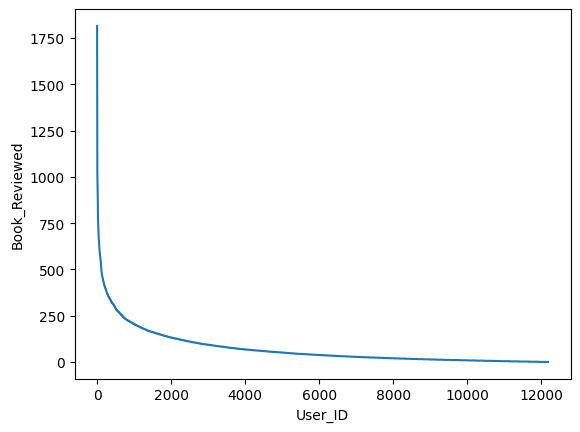

In [10]:
# setting default matplotlib plot style
mpl.rcParams.update(default_params)

# conclusion: power law of a few users with lots of reviews
plt.plot([x[1] for x in dist_user_reviews])
plt.ylabel('Book_Reviewed')
plt.xlabel('User_ID')
plt.show()

In [11]:
book_per_user = df.groupby(['user_id', 'book_id']).count()['review_id']
book_per_user

user_id                           book_id 
000a1016fda6008d1edbba720ca00851  178476      1
                                  215643      1
                                  458034      1
                                  3863861     1
                                  6040871     1
                                             ..
ffff7cafdaf5196383cb2efca08fb6fe  27161826    1
                                  27272506    1
                                  28260587    1
                                  28954189    1
                                  32571395    1
Name: review_id, Length: 900000, dtype: int64

In [12]:
# no review of the same book
book_per_user.max()

1

## Checking Reviews per Book

In [13]:
df['n_review_per_book'] = df.groupby('book_id')['book_id'].transform(len)

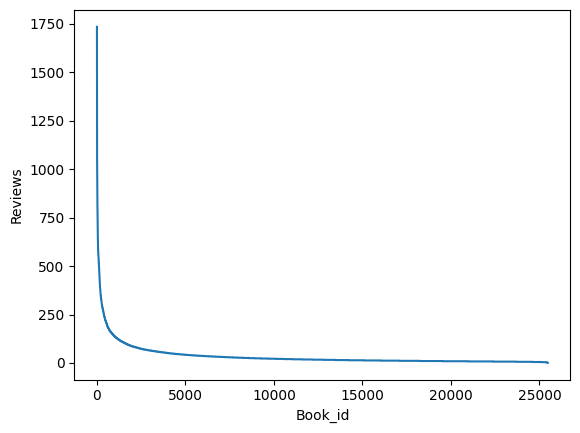

In [14]:
# too many reviews for some books, they need some balancing
reviews_x_book = [x[1] for x in sorted(list(set([(x, y) for x, y in df[['book_id', 'n_review_per_book']].values])),
                                       key = lambda x: -x[1])]
                                       
plt.plot(reviews_x_book)
plt.ylabel('Reviews')
plt.xlabel('Book_id')
plt.show()

# Preprocessing: Part I

## Balancing reviews per book
Sampling reviews pertaining to books with too many reviews

In [15]:
#average number of reviews per book
average_rev = int(sum(reviews_x_book) / len(reviews_x_book) // 1)
average_rev

35

In [16]:
indexes_to_keep = df[df['n_review_per_book'] <= average_rev].index
index_sampled = df[df['n_review_per_book'] > average_rev].groupby('book_id').sample(average_rev, random_state = 42).index

new_indexes = sorted(indexes_to_keep.tolist()+index_sampled.tolist())

In [17]:
df = df.loc[new_indexes].reset_index(drop=True)
len(df)

501745

## Dropping NaN genres

In [18]:
#Dropping NaN values
print(f"NaN values: {df.genre.isna().sum()}")
df.dropna(subset=['genre'], inplace=True)
print(f"NaN values: {df.genre.isna().sum()}")

NaN values: 71220
NaN values: 0


In [19]:
df_len = len(df)
print(f'New Dataset Length: {df_len}')

New Dataset Length: 430525


## Checking avg and max length of reviews

In [20]:
review_length = df.review_text.transform(len)

In [21]:
min_revlen = review_length.min()
min_revlen

2

In [22]:
mean_revlen = review_length.mean()
mean_revlen

1085.5727960048778

In [23]:
median_revlen = review_length.median()
median_revlen

630.0

In [24]:
max_revlen = review_length.max()
max_revlen

18912

## Cleaning Text

In [25]:
#cleaning review_text col
df.review_text = df.review_text.swifter.apply(lambda x: clean_tokens(x))
df.head()

Pandas Apply:   0%|          | 0/430525 [00:00<?, ?it/s]

,user_id,book_id,review_id,rating,review_text,date_added,date_updated,read_at,started_at,n_votes,n_comments,genre,n_review_per_book
0,8842281e1d1347389f2ab93d60773d4d,18245960,dfdbb7b0eb5a7e4c26d59a937e2e5feb,5,this is a special book. it started slow for ab...,Sun Jul 30 07:44:10 -0700 2017,Wed Aug 30 00:00:26 -0700 2017,Sat Aug 26 12:05:52 -0700 2017,Tue Aug 15 13:23:18 -0700 2017,28,1,Science Fiction,20
1,8842281e1d1347389f2ab93d60773d4d,16981,a5d2c3628987712d0e05c4f90798eb67,3,recommended by don katz. avail for free in dec...,Mon Dec 05 10:46:44 -0800 2016,Wed Mar 22 11:37:04 -0700 2017,NaN,NaN,1,0,Classics,54
2,8842281e1d1347389f2ab93d60773d4d,28684704,2ede853b14dc4583f96cf5d120af636f,3,"a fun, fast paced science fiction thriller. i ...",Tue Nov 15 11:29:22 -0800 2016,Mon Mar 20 23:40:27 -0700 2017,Sat Mar 18 23:22:42 -0700 2017,Fri Mar 17 23:45:40 -0700 2017,22,0,Science Fiction,34
3,8842281e1d1347389f2ab93d60773d4d,25884323,332732725863131279a8e345b63ac33e,4,"i really enjoyed this book, and there is a lot...",Mon Apr 25 09:31:23 -0700 2016,Mon Apr 25 09:31:23 -0700 2016,Sun Jun 26 00:00:00 -0700 2016,Sat May 28 00:00:00 -0700 2016,9,1,Science Fiction,9
6,8842281e1d1347389f2ab93d60773d4d,5577844,52c8ac49496c153e4a97161e36b2db55,5,a beautiful story. neil gaiman is truly a uniq...,Wed Sep 24 09:29:29 -0700 2014,Wed Oct 01 00:31:56 -0700 2014,Tue Sep 30 00:00:00 -0700 2014,Sun Sep 21 00:00:00 -0700 2014,5,1,Fantasy,14


## Dropping too short and too long reviews
At least they should be contained between the 5th and 95th percentile

In [26]:
fifth_percentile = review_length.quantile(0.05)
fifth_percentile

49.0

In [27]:
ninetyfifth_percentile = review_length.quantile(0.95)
ninetyfifth_percentile

3582.0

In [28]:
greater_than_first = review_length.values > fifth_percentile
lower_than_last = review_length.values < ninetyfifth_percentile

In [29]:
indices = [df.index[x] for x in np.where(greater_than_first & lower_than_last)[0]]

In [30]:
df = df.loc[indices]
df_len = len(df)
print(f'New Dataset Length: {df_len}')

New Dataset Length: 386940


## Storing the new training set

In [31]:
rev_df = df[["review_text","genre", "rating", "book_id"]]
del df

In [32]:
rev_df.head()

,review_text,genre,rating,book_id
0,this is a special book. it started slow for ab...,Science Fiction,5,18245960
1,recommended by don katz. avail for free in dec...,Classics,3,16981
2,"a fun, fast paced science fiction thriller. i ...",Science Fiction,3,28684704
6,a beautiful story. neil gaiman is truly a uniq...,Fantasy,5,5577844
8,"what a fun series. i loved wool, and dust and ...",Science Fiction,4,17855756


In [33]:
len(rev_df)

386940

## Filtering the genres

In [34]:
list(enumerate(rev_df.genre.value_counts().items()))[:10]

[(0, ('Romance', 98194)),
 (1, ('Fantasy', 89108)),
 (2, ('Young Adult', 56133)),
 (3, ('Fiction', 26432)),
 (4, ('Science Fiction', 17946)),
 (5, ('Mystery', 16510)),
 (6, ('Sequential Art', 15714)),
 (7, ('Historical', 11679)),
 (8, ('Horror', 8971)),
 (9, ('Classics', 6748))]

In [35]:
# made it slightly more readable
genres_corresp = ((("Fantasy", "Superheroes", "Shapeshifters", "Science Fiction Fantasy"), #-->
                   ("Fantasy")),
                  (("Romance", "Erotica", "Polyamorous", "Category Romance"), #-->
                   ("Romance")),
                  (("Fiction", "Young Adult", "New Adult", "Womens Fiction", "Adult Fiction", 
                    "Christian Fiction", "Realistic Fiction", "Fan Fiction", "Magical Realism"), #-->
                   ("Fiction")),
                  (("Sequential Art", "Music", "Couture"), #-->
                   ("Art")),
                  (("Thriller", "Mystery", "Crime"), #-->
                   ("Thriller")),
                  (("Science Fiction", ), #just add a single comma to not loop in the string -->
                   ("Science Fiction")),
                  (("Horror", "Paranormal", "Dark", "Suspense"), #-->
                   ("Horror")),
                  (("Classics", "Contemporary", "Poetry", "Plays"), #-->
                   ("Literature")),
                  (("Nonfiction", "Autobiography", "Biography"), #-->
                   ("NonFiction")),
                  (("Historical", "History", "War", "Mythology"), #-->
                   ("History")))

In [36]:
genres_to_keep_dict = {k : v for ks, v in genres_corresp for k in ks}
genres_to_keep_dict

{'Fantasy': 'Fantasy',
 'Superheroes': 'Fantasy',
 'Shapeshifters': 'Fantasy',
 'Science Fiction Fantasy': 'Fantasy',
 'Romance': 'Romance',
 'Erotica': 'Romance',
 'Polyamorous': 'Romance',
 'Category Romance': 'Romance',
 'Fiction': 'Fiction',
 'Young Adult': 'Fiction',
 'New Adult': 'Fiction',
 'Womens Fiction': 'Fiction',
 'Adult Fiction': 'Fiction',
 'Christian Fiction': 'Fiction',
 'Realistic Fiction': 'Fiction',
 'Fan Fiction': 'Fiction',
 'Magical Realism': 'Fiction',
 'Sequential Art': 'Art',
 'Music': 'Art',
 'Couture': 'Art',
 'Thriller': 'Thriller',
 'Mystery': 'Thriller',
 'Crime': 'Thriller',
 'Science Fiction': 'Science Fiction',
 'Horror': 'Horror',
 'Paranormal': 'Horror',
 'Dark': 'Horror',
 'Suspense': 'Horror',
 'Classics': 'Literature',
 'Contemporary': 'Literature',
 'Poetry': 'Literature',
 'Plays': 'Literature',
 'Nonfiction': 'NonFiction',
 'Autobiography': 'NonFiction',
 'Biography': 'NonFiction',
 'Historical': 'History',
 'History': 'History',
 'War': 'Histo

In [37]:
print(f"Initial rows: {len(rev_df)}")
rev_df = rev_df[rev_df.genre.isin(genres_to_keep_dict.keys())].reset_index(drop=True)
print(f"Filtered len: {len(rev_df)}")

Initial rows: 386940
Filtered len: 377667


In [38]:
rev_df.genre = rev_df.genre.map(lambda genere: genres_to_keep_dict[genere])
rev_df.head()

,review_text,genre,rating,book_id
0,this is a special book. it started slow for ab...,Science Fiction,5,18245960
1,recommended by don katz. avail for free in dec...,Literature,3,16981
2,"a fun, fast paced science fiction thriller. i ...",Science Fiction,3,28684704
3,a beautiful story. neil gaiman is truly a uniq...,Fantasy,5,5577844
4,"what a fun series. i loved wool, and dust and ...",Science Fiction,4,17855756


In [39]:
rev_df.genre.value_counts()

Romance            100900
Fiction             92134
Fantasy             89182
Thriller            19564
Science Fiction     17946
Horror              16302
Art                 15747
History             12291
Literature           8675
NonFiction           4926
Name: genre, dtype: int64

## Average Length of reviews per genere

In [40]:
rev_length = rev_df.review_text.transform(len)

length_df = pd.DataFrame()

max_length = rev_df.genre.value_counts()[0]

for genre in rev_df.genre.unique():
    records = rev_length[rev_df['genre'] == genre].values.tolist()
    increase_wnan = [np.nan]*(max_length-len(records))
    records += increase_wnan
    length_df[genre] = records

/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


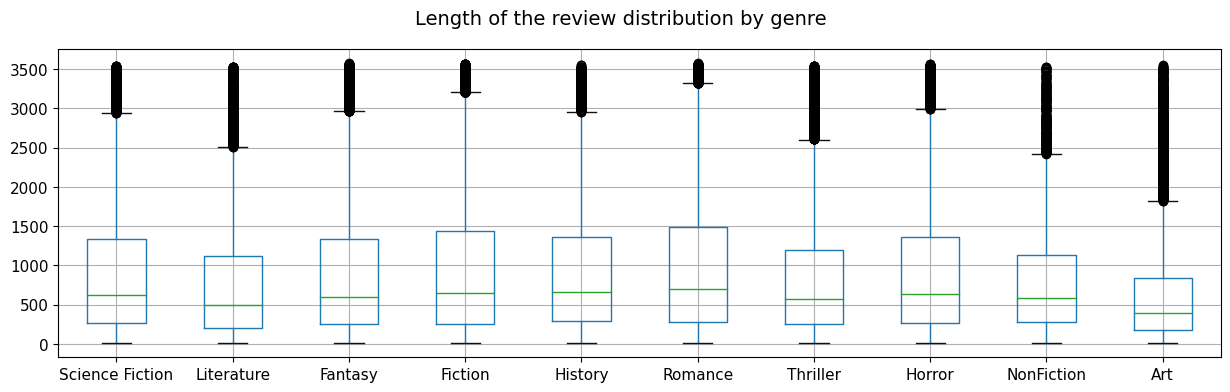

In [41]:
fig = plt.figure(figsize=(15, 4)) 
fig.suptitle('Length of the review distribution by genre', fontsize=14)
length_df.boxplot(column=[col for col in length_df.columns], fontsize=11)
plt.show()

del length_df

## Merging Classes
After checking performances on validation we concluded it was too difficult to produce results with these many genres

In [42]:
rev_df.genre.unique()

array(['Science Fiction', 'Literature', 'Fantasy', 'Fiction', 'History',
       'Romance', 'Thriller', 'Horror', 'NonFiction', 'Art'], dtype=object)

In [43]:
new_genres = {'Romance': 'Romance',
              'Fiction' : 'Fiction',
              'Fantasy' : 'Fiction',
              'Thriller' : 'Mystery',
              'Horror' : 'Mystery', 
              'NonFiction' : 'NonFiction',
              'Literature' : 'NonFiction',
              'History' : 'NonFiction', 
              'Classics' : 'NonFiction', 
              'Science Fiction' : 'Science Fiction', 
              'Art' : 'Art'}

In [44]:
rev_df['genre'] = rev_df.genre.map(lambda genere: new_genres[genere])

In [45]:
rev_df.head()

,review_text,genre,rating,book_id
0,this is a special book. it started slow for ab...,Science Fiction,5,18245960
1,recommended by don katz. avail for free in dec...,NonFiction,3,16981
2,"a fun, fast paced science fiction thriller. i ...",Science Fiction,3,28684704
3,a beautiful story. neil gaiman is truly a uniq...,Fiction,5,5577844
4,"what a fun series. i loved wool, and dust and ...",Science Fiction,4,17855756


## Plotting Genres distribution: Before Undersampling

In [46]:
# setting default matplotlib plot style
mpl.rcParams.update(default_params)

In [47]:
rev_df.genre.value_counts()

Fiction            181316
Romance            100900
Mystery             35866
NonFiction          25892
Science Fiction     17946
Art                 15747
Name: genre, dtype: int64

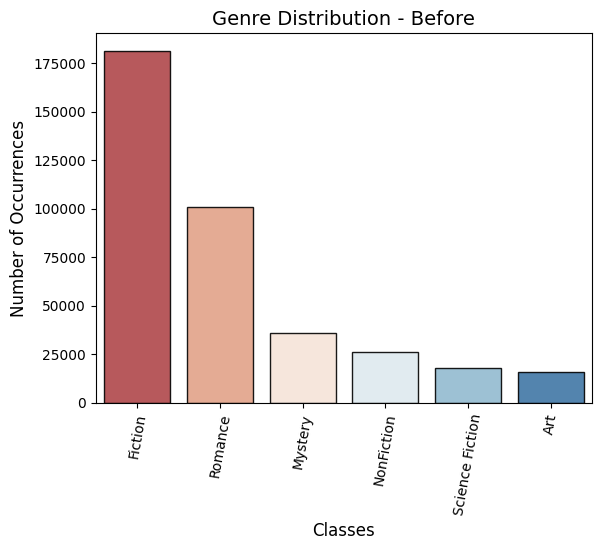

In [48]:
sns.barplot([x for x in rev_df.genre.value_counts().index],
            [y for y in rev_df.genre.value_counts().values],
            alpha=0.9, palette="RdBu", edgecolor="black")

plt.title('Genre Distribution - Before',fontsize=14)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Classes', fontsize=12)
plt.xticks(rotation=80)
plt.show()

## Class Undersampling

In [49]:
n = 2000
genres_w_more_than_n_reviews = rev_df.groupby('genre')['genre'].transform(len) >= n
#undersampling genres with more than 2000 reviews to 2000
rev_df_reduced = pd.concat((rev_df[genres_w_more_than_n_reviews].groupby('genre').sample(n=n, random_state = 42), 
                            rev_df[~genres_w_more_than_n_reviews]), ignore_index=True)

## Plotting Genres distribution: After Undersampling

In [50]:
rev_df_reduced.genre.value_counts()

Art                2000
Fiction            2000
Mystery            2000
NonFiction         2000
Romance            2000
Science Fiction    2000
Name: genre, dtype: int64

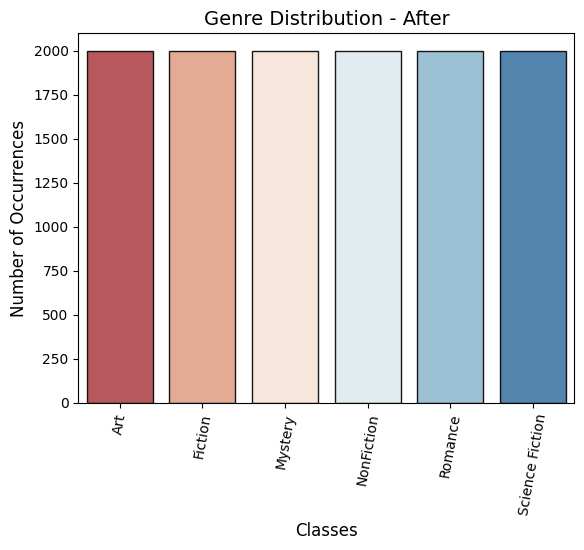

In [51]:
sns.barplot([x for x in rev_df_reduced.genre.value_counts().index],
            [y for y in rev_df_reduced.genre.value_counts().values],
            alpha=0.9, palette="RdBu", edgecolor="black")

plt.title('Genre Distribution - After',fontsize=14)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Classes', fontsize=12)
plt.xticks(rotation=80)
plt.show()

# Preprocessing: Part II

In [52]:
rev_df = rev_df_reduced
del rev_df_reduced

## Tokeninzing the Text

In [53]:
rev_df["tokenized_text"] = rev_df.review_text.swifter.apply(lambda x: word_tokenize(x))
rev_df.head()

Pandas Apply:   0%|          | 0/12000 [00:00<?, ?it/s]

,review_text,genre,rating,book_id,tokenized_text
0,i know it's cheaterish and stupid to review a ...,Art,5,156532,"[i, know, it, 's, cheaterish, and, stupid, to,..."
1,". superman is dealing with his new powers, plu...",Art,3,26067595,"[., superman, is, dealing, with, his, new, pow..."
2,i actually enjoyed this one. i feel like this ...,Art,4,3430737,"[i, actually, enjoyed, this, one, ., i, feel, ..."
3,i can't help but give this five stars. i love ...,Art,5,8601702,"[i, ca, n't, help, but, give, this, five, star..."
4,just completely awesome! forget breaking the ...,Art,5,19351043,"[just, completely, awesome, !, forget, breakin..."


## POS tagging

The Part Of Speech tag. Valid options are `"n"` for nouns, `"v"` for verbs, `"a"` for adjectives, `"r"` for adverbs and `"s"` for satellite adjectives.

In [54]:
rev_df["postagged_text"] = rev_df.tokenized_text.swifter.apply(lambda x: nltk.pos_tag(x))

Pandas Apply:   0%|          | 0/12000 [00:00<?, ?it/s]

Dropping the tokenized text as we have an annotated version

In [55]:
rev_df.drop('tokenized_text', axis = 1, inplace = True)

In [56]:
list_of_tags = rev_df.postagged_text.swifter.apply(lambda x: [el[1] for el in x if len(el) == 2]).tolist()
set_of_tags = set()

for ls in list_of_tags:
    for tag in ls:
        set_of_tags.add(tag)

Pandas Apply:   0%|          | 0/12000 [00:00<?, ?it/s]

In [57]:
pos_mapper = {k : get_wordnet_pos(k) for k in set_of_tags}

In [58]:
list(pos_mapper.items())[:5]

[('WDT', None), ('VB', 'v'), ('PRP$', None), ('RBS', 'r'), ('NNS', 'n')]

## Removing Stop Words

In [59]:
print(f"e.g. a token list len before: {len(rev_df.postagged_text[0])}")
rev_df["postagged_text"] = remove_stop_words(rev_df["postagged_text"], pos = True)
print(f"e.g. a token list len after: {len(rev_df.postagged_text[0])}")

e.g. a token list len before: 174
e.g. a token list len after: 50


## Filtering out short words

In [60]:
rev_df.head()

,review_text,genre,rating,book_id,postagged_text
0,i know it's cheaterish and stupid to review a ...,Art,5,156532,"[(know, VBP), (cheaterish, JJ), (stupid, JJ), ..."
1,". superman is dealing with his new powers, plu...",Art,3,26067595,"[(superman, NN), (dealing, VBG), (new, JJ), (p..."
2,i actually enjoyed this one. i feel like this ...,Art,4,3430737,"[(actually, RB), (enjoyed, VBD), (feel, VBP), ..."
3,i can't help but give this five stars. i love ...,Art,5,8601702,"[(ca, MD), (help, VB), (stars, NNS), (love, VB..."
4,just completely awesome! forget breaking the ...,Art,5,19351043,"[(completely, RB), (awesome, JJ), (forget, NN)..."


In [61]:
# minimum length of the remaining words of the fixed tokenized text 
print('Minimum Length of a Word in the Dataset:', end=' ')
min([min(x) for x in rev_df.postagged_text.map(lambda x: ([len(el[0]) for el in x])) if x != []])

Minimum Length of a Word in the Dataset: 

1

In [62]:
#filtering the words with a length less than 2
rev_df["postagged_text"] = rev_df.postagged_text.map(lambda x: [el for el in x if len(el[0]) > 2])

Checking if both the tokenized text and the postagged one matches the new filtering

In [63]:
# minimum length of the remaining words of the fixed tokenized text after update
print('Minimum Length of a Word in the Dataset:', end=' ')
min([min(x) for x in rev_df.postagged_text.map(lambda x: ([len(el[0]) for el in x])) if x != []])

Minimum Length of a Word in the Dataset: 

3

## Lemmatize the Tokens

In [64]:
def lemmatize_row(row):
    lemmatizer = WordNetLemmatizer()
    lemmatized_row = list()
    
    for token, pos in row:
        if pos_mapper[pos] is None:
            lemma = lemmatizer.lemmatize(token)
        else:
            lemma = lemmatizer.lemmatize(token, pos = pos_mapper[pos])

        lemmatized_row.append(lemma) # we discarded the pos here

    return lemmatized_row

In [65]:
#lemmatizing
rev_df['lemmatized_text'] = rev_df.postagged_text.swifter.apply(lambda x: lemmatize_row(x))

Pandas Apply:   0%|          | 0/12000 [00:00<?, ?it/s]

In [66]:
rev_df.drop('postagged_text', axis = 1, inplace = True)

In [67]:
rev_df.head()

,review_text,genre,rating,book_id,lemmatized_text
0,i know it's cheaterish and stupid to review a ...,Art,5,156532,"[know, cheaterish, stupid, review, series, ind..."
1,". superman is dealing with his new powers, plu...",Art,3,26067595,"[superman, deal, new, power, plus, losing, bla..."
2,i actually enjoyed this one. i feel like this ...,Art,4,3430737,"[actually, enjoy, feel, like, series, start, h..."
3,i can't help but give this five stars. i love ...,Art,5,8601702,"[help, star, love, series, funny, stingy, come..."
4,just completely awesome! forget breaking the ...,Art,5,19351043,"[completely, awesome, forget, break, mold, loo..."


# Saving the Training Set

In [68]:
rev_df.to_csv('./training_set_preprocessed.csv', index = False)

# EDA: Part II

## NER

Before cleaning the review texts, NER and chuncking are applied on some reviews

In [69]:
#load spacy model 
nlp = spacy.load("en_core_web_sm")

In [76]:
try_these = rev_df['review_text'].transform(lambda x: len(x.split())).sort_values()[50:60].index

In [77]:
for i in try_these:
    print(i, nlp(rev_df.review_text[i]).ents)

2862 ()
7360 ()
233 ()
6528 ()
341 ()
11216 ()
10674 (last day, amazon, june 11th)
10427 (ancillary justice  ann leckie,)
10708 ()
4548 ()


In [78]:
# Doc example for chunking and NER visualization
eg_rev = 10674
doc = nlp(rev_df.review_text[eg_rev])

In [79]:
print(doc.ents)

(last day, amazon, june 11th)


In [80]:
# Chunking 
[chunk.text for chunk in doc.noun_chunks]

['amazon', 'june 11th']

In [81]:
rev_df['lemmatized_text'].loc[eg_rev]

['day', 'free', 'amazon', 'june']

In [82]:
for entity in doc.ents:
    print(entity.text, entity.label_)

last day DATE
amazon ORG
june 11th DATE


In [83]:
# The 'ent' style shows a named entity visualization
displacy.render(doc, style="ent", jupyter=True )

In [84]:
# Doc example for dependency parse tree
example = nlp(rev_df.review_text[eg_rev])

This was an interesting review considering it was borderlining free advertisement

In [85]:
# The 'dep' style shows a dependency parse tree with POS(Part-of-Speech) tags and syntactic dependencies 
displacy.render(example, style="dep", jupyter=True, options= {'distance': 110} )

## Extracting Dictionary 

In [86]:
dict_count = dict(sorted(nltk.FreqDist([word for text in rev_df["lemmatized_text"] for word in text]).items(), 
                         key=lambda x: x[1], reverse=True))

In [87]:
list(dict_count.items())[:6]

[('book', 20609),
 ('read', 11077),
 ('like', 10322),
 ('story', 9723),
 ('love', 8433),
 ('character', 7998)]

In [88]:
# getting the max frequency of a word that appear in at most 99% of the review corpus 
maximum_threshold = np.quantile(list(dict_count.values()), 0.99)

In [89]:
# filtering out the extremes of the distribution
dict_count_fixed = {k:v for k,v in dict_count.items() if v > 5 and v < maximum_threshold}
# dict_count_fixed

In [90]:
dictionary = set(dict_count_fixed.keys())
# dictionary
len(dictionary)

9222

## Visualizations for the Genre

In [91]:
# Instantiating the vectorizer
tfidf = TfidfVectorizer()

In [92]:
# joining the text back to a string
rev_df['lemmatized_joined'] = rev_df["lemmatized_text"].swifter.apply(lambda x: ' '.join(x))

# setting the corpus and the labels
corpus = rev_df["lemmatized_joined"]
labels = rev_df['genre']

# vectorizing
matrix = tfidf.fit_transform(corpus)

Pandas Apply:   0%|          | 0/12000 [00:00<?, ?it/s]

Lots of insight could be derived from the following UMAP projection. It's not possible to fix the projection across multiple runs, thus a picture of one of the outputs is being shown:

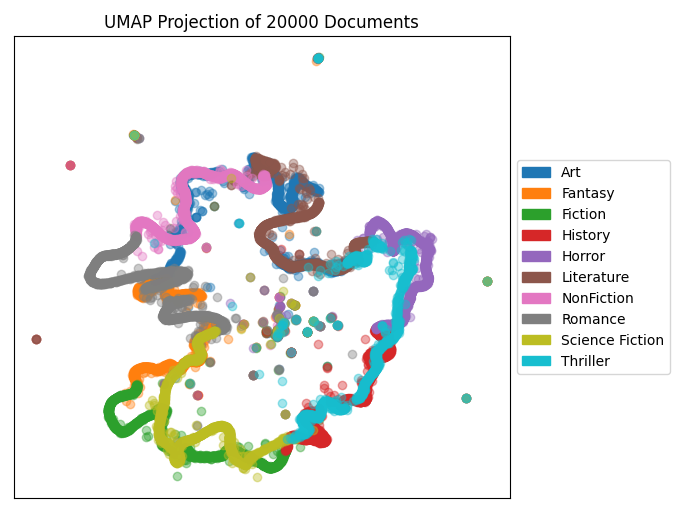

There seems to be some sort of ring connection between the different genres, as it can be seen Romance and Fantasy overlaps in some parts while Thriller overlaps entirely with both History and Horror, Science fiction instead seems to be the closse to Fiction, while Literature and non-fiction seems to converge and mix together on Art

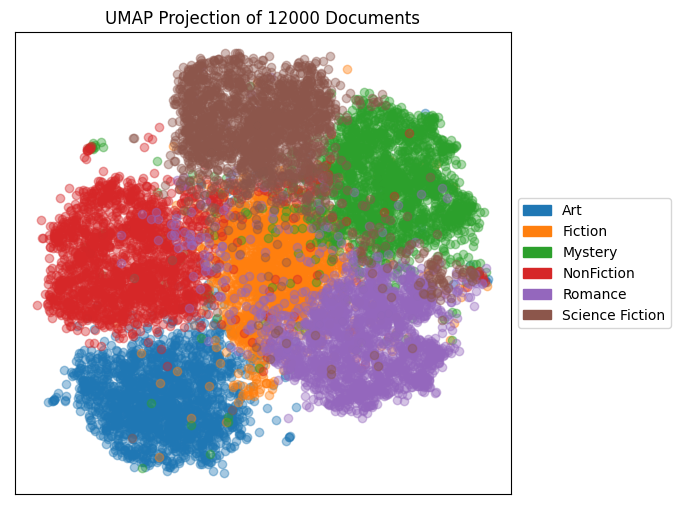

In [93]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)
umap = UMAPVisualizer(ax = ax, alpha = 0.4)
umap.fit(matrix, labels, random_state = 42)
umap.show()

Regarding tSNE nothing of relevance appeared from the plot out of the fact that it seems there is some stronger internal connection with reviews related with Art and Thriller

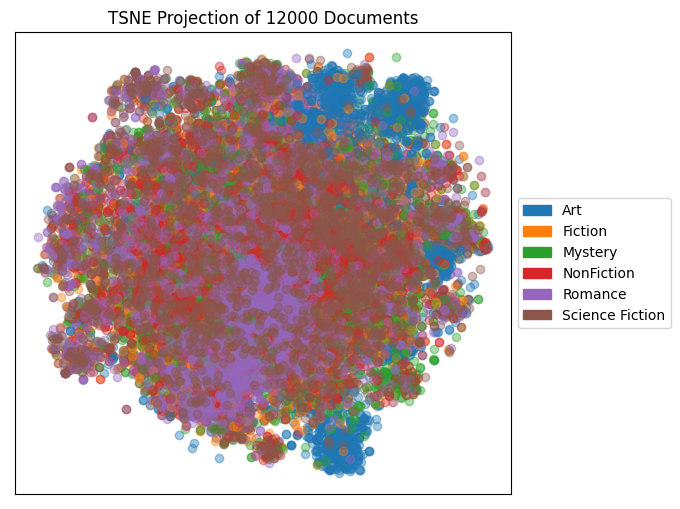

In [94]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)
tsne = TSNEVisualizer(ax = ax, alpha = 0.4)
tsne.fit(matrix, labels, random_state = 42)
tsne.fit(matrix, labels, random_state = 42)
tsne.show()

## Topic Modeling

In [95]:
lemma_docs = rev_df["lemmatized_text"].values.tolist()

# Add bigrams to docs (only ones that appear 20 times or more).
bigram = Phrases(lemma_docs, min_count=20)

for idx in range(len(lemma_docs)):
    for token in bigram[lemma_docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            # I keep both single words and bigrams in the document
            lemma_docs[idx].append(token)

/usr/local/lib/python3.8/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [96]:
alternative_dictionary = Dictionary(lemma_docs)
print('Before Removal', len(alternative_dictionary))
# Filter out words that occur less than 5 documents, or more than 70% of the documents.
alternative_dictionary.filter_extremes(no_below=5, no_above=0.70)
print('After Filtering', len(alternative_dictionary))
not_filter = set(alternative_dictionary.values()).intersection(dictionary)
not_filter_idx = [alternative_dictionary.token2id[token] for token in not_filter]
alternative_dictionary.filter_tokens(good_ids=not_filter_idx)
print('After Intersection', len(alternative_dictionary))

Before Removal 38191
After Filtering 9854
After Intersection 8474


In [97]:
# Bag-of-words representation of the documents.
corpus = [alternative_dictionary.doc2bow(doc) for doc in lemma_docs]

In [98]:
for key, idxinfo in zip([alternative_dictionary[w[0]] for w in corpus[5]], corpus[5]):
    print (key, idxinfo)

clark (17, 1)
suffers (78, 1)
accept (90, 1)
advice (91, 1)
agent (92, 1)
annie (93, 4)
appearance (94, 1)
assemble (95, 1)
bar (96, 1)
bone (97, 2)
border (98, 1)
btw (99, 1)
characterization (100, 1)
choice (101, 1)
comment (102, 1)
complete (103, 1)
control (104, 1)
crime (105, 1)
danger (106, 1)
define (107, 1)
detailed (108, 1)
disappointing (109, 1)
display (110, 1)
door (111, 1)
drift (112, 3)
explanation (113, 3)
forgive (114, 1)
fringe (115, 1)
hooker (116, 1)
horribly (117, 1)
insult (118, 1)
introduce (119, 1)
jeff (120, 1)
macho (121, 1)
maya (122, 4)
maze (123, 2)
mess (124, 1)
misogynistic (125, 1)
museum (126, 3)
necklace (127, 1)
newly (128, 1)
notebook (129, 1)
offensive (130, 1)
pace (131, 1)
parallel (132, 1)
particular (133, 2)
path (134, 1)
piece (135, 1)
plant (136, 1)
playing (137, 1)
porn (138, 1)
portal (139, 1)
pose (140, 1)
president (141, 1)
profound (142, 1)
promise (143, 1)
purpose (144, 1)
randomly (145, 1)
readable (146, 1)
rescue (147, 1)
research (148,

In [99]:
print(f'Number of unique tokens: {len(alternative_dictionary)}')
print(f'Number of documents: {len(corpus)}')

Number of unique tokens: 8474
Number of documents: 12000


In [100]:
# Train LDA model.
from gensim.models import LdaModel

# Set training parameters.
num_topics = len(np.unique(rev_df['genre']))
chunksize = 2000
passes = 20
iterations = 400
eval_every = None  # Don't evaluate model perplexity, takes too much time.

# Make an index to word dictionary.
temp = alternative_dictionary[0]  # This is only to "load" the dictionary.
id2word = alternative_dictionary.id2token

model = LdaModel(corpus=corpus,
                 id2word=id2word,
                 chunksize=chunksize,
                 alpha='auto',
                 eta='auto',
                 iterations=iterations,
                 num_topics=num_topics,
                 passes=passes,
                 eval_every=eval_every
                 )

In [101]:
top_topics = model.top_topics(corpus)

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
print(f'Average topic coherence: {avg_topic_coherence:.4f}.')

Average topic coherence: -9.1320.


I see some words which appear in a lot of books going to the same topic, while I can recognize some thriller and romance -like words...

In [102]:
topic_clust_words = list()
cluster = 0

for topic in top_topics:
    print('\n', topic[1], [w[1] for w in topic[0]])
    representative_word = [w[1] for w in topic[0]][0]
    cluster += 1
    topic_clust_words.append((cluster, representative_word))


 -3.6994758672715062 ['concept', 'narrator', 'setting', 'narrative', 'pace', 'excellent', 'difficult', 'base', 'classic', 'unfortunately', 'extremely', 'pov', 'perspective', 'language', 'connect', 'bore', 'steampunk', 'clear', 'actual', 'boring']

 -4.300343837725214 ['alien', 'ship', 'planet', 'game', 'earth', 'trilogy', 'jane', 'scifi', 'wow', 'thriller', 'race', 'memory', 'battle', 'universe', 'zombie', 'forget', 'return', 'water', 'allow', 'survive']

 -8.520963657304714 ['fuck', 'tear', 'audiobook', 'dream', 'summer', 'hunter', 'henry', 'steamy', 'emily', 'mia', 'claire', 'soul', 'hea', 'hurt', 'horrible', 'blog', 'harry', 'max', 'dirty', 'peter']

 -11.141009651815885 ['white', 'anne', 'gabriel', 'marry', 'position', 'charlie', 'fairy', 'lily', 'marriage', 'ivy', 'evil', 'charles', 'money', 'worldbuilding', 'seat', 'maggie', 'snow', 'winter', 'blah', 'sophie']

 -12.739349027969231 ['adam', 'alex', 'eve', 'kindle', 'dog', 'career', 'batman', 'debut', 'paragraph', 'juliette', 'be

### Get insight on the genres with topic words

In [103]:
topic_clust_words

[(1, 'concept'),
 (2, 'alien'),
 (3, 'fuck'),
 (4, 'white'),
 (5, 'adam'),
 (6, 'mile')]

In [104]:
def frequency_per_genre(df, genre):
    df_review = df[df.genre == genre]
    
    dict_count = dict(sorted(nltk.FreqDist([word for text in df_review["lemmatized_text"] for word in text]).items(), 
                             key=lambda x: x[1], reverse=True)[20:])
    
    return dict_count

In [105]:
from tqdm import tqdm

cluster_assignment = list()

for genre in tqdm(rev_df['genre'].unique()):
    for cluster, topic_word in topic_clust_words:
        try:
            freq = frequency_per_genre(rev_df, genre)[topic_word]
        except:
            freq = 0
        cluster_assignment.append((cluster, genre, topic_word, freq))

100%|██████████| 6/6 [00:02<00:00,  2.07it/s]


Extracting for each word and genre pair the frequency of the word in the reviews of that genre, then extracting the maximum frequency for each genre

In [106]:
topic_clust_assignment = pd.DataFrame(cluster_assignment, columns = ['cluster', 'genre', 'topic_word', 'freq'])
max_freq_of_genre = topic_clust_assignment[['genre', 'freq']].groupby('genre').max().reset_index()
max_freq_of_genre = max_freq_of_genre.merge(topic_clust_assignment, on=['genre', 'freq'])

In [107]:
max_freq_of_genre.head(10)

,genre,freq,cluster,topic_word
0,Art,67,4,white
1,Fiction,63,1,concept
2,Mystery,60,3,fuck
3,NonFiction,76,4,white
4,Romance,85,3,fuck
5,Science Fiction,229,2,alien


Getting the maximum frequency topic_word per genre, considering the selection of topic words is a almost randomized process we decided to save some results to make some considerations:

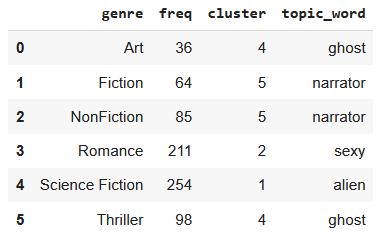

As it can be seen there are some words that seem to be semantically strictly connected with some genres, like ghost and narrator

## Considerations on TF-IDF values on unigrams, bigrams and trigrams

In [108]:
# convert into numpy array with todense()
tfidf_values = pd.DataFrame(matrix[32].T.todense(),
                            index=tfidf.get_feature_names(), columns=["TF-IDF"]) 
tfidf_values = tfidf_values.sort_values('TF-IDF', ascending=False)
tfidf_values[:10]

,TF-IDF
kamala,0.380989
issue,0.290963
shipper,0.221333
sad,0.220696
yes,0.208113
bruno,0.206521
shoehorn,0.193648
loki,0.192022
consent,0.186399
bonus,0.160007


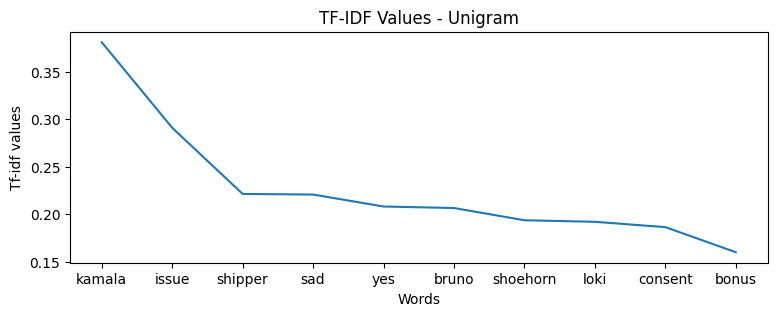

In [109]:
p = [x for x in tfidf_values.values][:10]
n = [x for x in tfidf_values.index][:10]
plt.figure(figsize=(9,3))
plt.title("TF-IDF Values - Unigram")
plt.xlabel("Words")
plt.ylabel("Tf-idf values")
plt.plot(n,p)
plt.show()

The higher the TF-IDF score the more important/ relevant the term is. When a term gets less relevant, its TF-IDF score will tend to 0. 

In [110]:
corpus = rev_df['lemmatized_joined']

In [111]:
# initialize tfidf considering bigrams
tfidf_bi = TfidfVectorizer(ngram_range = (2,2))
matrix_bi = tfidf_bi.fit_transform(corpus)

tfidf_values_bi = pd.DataFrame(matrix_bi[32].T.todense(),
                               index=tfidf_bi.get_feature_names(), columns=["TF-IDF_Bigrams"]) 
tfidf_values_bi = tfidf_values_bi.sort_values('TF-IDF_Bigrams', ascending=False)
tfidf_values_bi[:10]

,TF-IDF_Bigrams
marvel stand,0.153403
romance fine,0.153403
bruno shipper,0.153403
boy volume,0.153403
mix issue,0.153403
yes appearance,0.153403
yes sit,0.153403
slip good,0.153403
dance kamala,0.153403
felt teen,0.153403


In [112]:
# initialize tfidf considering bigrams
tfidf_tri = TfidfVectorizer(ngram_range = (3,3))
matrix_tri = tfidf_tri.fit_transform(corpus)

tfidf_values_tri = pd.DataFrame(matrix_tri[32].T.todense(),
                                index=tfidf_tri.get_feature_names(), columns=["TF-IDF_Trigrams"]) 
tfidf_values_tri = tfidf_values_tri.sort_values('TF-IDF_Trigrams', ascending=False)
tfidf_values_tri[:10]

,TF-IDF_Trigrams
shipper point prepare,0.14948
consent yes sit,0.14948
slip good measure,0.14948
turn totally come,0.14948
stand little dialogue,0.14948
felt teen romance,0.14948
little dialogue issue,0.14948
bonus issue slip,0.14948
kamala crush boy,0.14948
dialogue issue consent,0.14948


In both bigrams and trigrams , the tf-idf values are similar

## Sentiment Analysis
Testing on lemmatized text because of fewer tokens per documents (It will be tested on the original sentences later)

In [113]:
tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

def sentiment_score(review):
    tokens = tokenizer.encode(review, return_tensors='pt')
    result = model(tokens)
    return int(torch.argmax(result.logits))+1

Downloading:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/953 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/872k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/669M [00:00<?, ?B/s]

In [114]:
# For 12.000 records it requires half an hour or so
sample_sentiment = rev_df['lemmatized_joined']
index_sample = sample_sentiment.index

In [115]:
start = time.time()
sentiment_score(sample_sentiment.loc[index_sample[0]])
end = time.time()
print(end-start)

0.5531024932861328


In [116]:
sentiment_result = sample_sentiment.swifter.apply(lambda x: sentiment_score(x[:512]))

Pandas Apply:   0%|          | 0/12000 [00:00<?, ?it/s]

In [117]:
sentiment_df = pd.concat((rev_df['review_text'].loc[index_sample], sentiment_result), axis= 1).rename(columns={'lemmatized_joined':"sentiment"}).reset_index(drop=True)

In [118]:
sentiment_df.head()

,review_text,sentiment
0,i know it's cheaterish and stupid to review a ...,1
1,". superman is dealing with his new powers, plu...",1
2,i actually enjoyed this one. i feel like this ...,5
3,i can't help but give this five stars. i love ...,5
4,just completely awesome! forget breaking the ...,5


In [119]:
sentiment_df.loc[sentiment_df.index[1]]['review_text'], sentiment_df.loc[sentiment_df.index[1]]['sentiment']

(". superman is dealing with his new powers, plus the losing of some, and now he's being blackmailed to help some villainous corporation or his secret identity will be revealed. there were some good character moments between lois and clark, and seeing the justice league help clark as he's trying to figure out limits to his powers and all that's going. it left the story in a very new direction, and i'd like to read more.",
 1)

In [120]:
sentiment_df.loc[sentiment_df.index[3]]['review_text'], sentiment_df.loc[sentiment_df.index[3]]['sentiment']

("i can't help but give this five stars. i love this series very much. it's funny. i can be stingy when it comes for fairest or cinderella, but i have trouble doing that with fables, except fables, vol.  the great fables crossover lost me because it was too smug i think and also because jack gets on my everloving nerves and he was in that book too much for my tastes. however, we are back on our five star streak with fables here.  rose red finally gets her head together after the very painful and personal loss she and the fables community suffers. in other to do that, she has to revisit the willful mistakes of her past. we go back to rose red and snow white's childhood as the innocent children of a forestdwelling mother who meet a friendly bear seeking a place by the fire, and what ensues from that point. i recently reread this fairy tale, and so it was fun to see willingham retell it here, but add some nuances that point to why rose red was such an allfired brat and the origins of her 

### Checking Ratings-Sentiment Metrics and Correlation
Trying to see if the sentiment analysis is a good predictor of the ratings:

It seems it is not

In [121]:
from sklearn.metrics import classification_report

sentiment_df['rating'] = rev_df.rating.replace(0, 1)

print(classification_report(sentiment_df.rating, sentiment_df.sentiment))

              precision    recall  f1-score   support

           1       0.12      0.59      0.20       747
           2       0.20      0.21      0.21       984
           3       0.35      0.23      0.28      2810
           4       0.46      0.29      0.35      4399
           5       0.47      0.44      0.45      3060

    accuracy                           0.32     12000
   macro avg       0.32      0.35      0.30     12000
weighted avg       0.39      0.32      0.34     12000



In [122]:
sentiment_df.corr()

,sentiment,rating
sentiment,1.000000,0.289336
rating,0.289336,1.000000


## WorldCloud

In [123]:
def generate_wordcloud_genre(df, genre):
    f = frequency_per_genre(df, genre)
    mask = np.array(Image.open(genre + ".png"))
    wc = WordCloud(background_color="white", 
                   max_words=200, max_font_size=100, 
                   random_state=42, mask = mask).generate_from_frequencies(f)
    plt.figure(figsize=(20,6))
    plt.imshow(wc, interpolation = 'bilinear')
    plt.title(genre)
    plt.axis("off")
    plt.show()

In [124]:
import urllib.request

# Downloading pictures for word clouds
fiction_url = 'https://cdn-icons-png.flaticon.com/512/523/523813.png'
art_url = 'https://www.freepnglogos.com/uploads/ghost-png/creepy-ghost-svg-png-icon-download-24.png'
mystery_url = 'https://assets-global.website-files.com/5eea2efbaac9091a52bc9645/625fbd4ad3c560021d7a058b_lente%20mobile.png'
romance_url = 'https://cdn-icons-png.flaticon.com/512/1216/1216686.png'
scifi_url = 'https://cdn-icons-png.flaticon.com/512/190/190276.png'

genre_url = {'Fiction' : fiction_url, 'Art' : art_url, 
             'Mystery' : mystery_url, 'Romance' : romance_url, 
             'Science Fiction' : scifi_url}

for genre, url in genre_url.items():
    urllib.request.urlretrieve(url, genre+'.png')

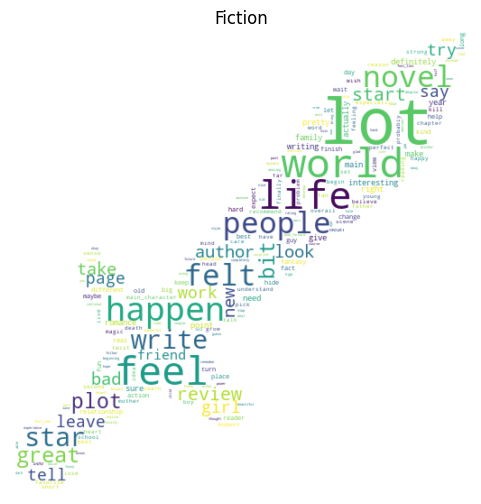

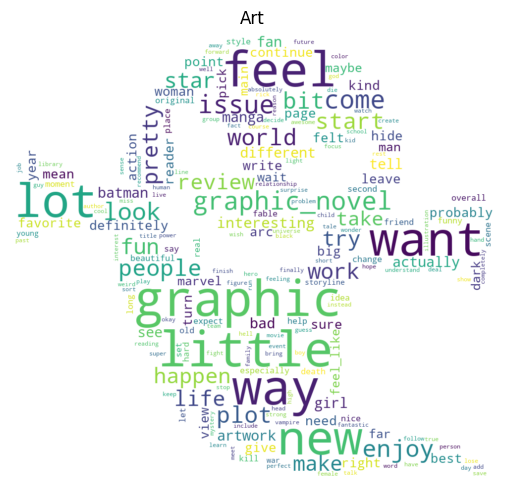

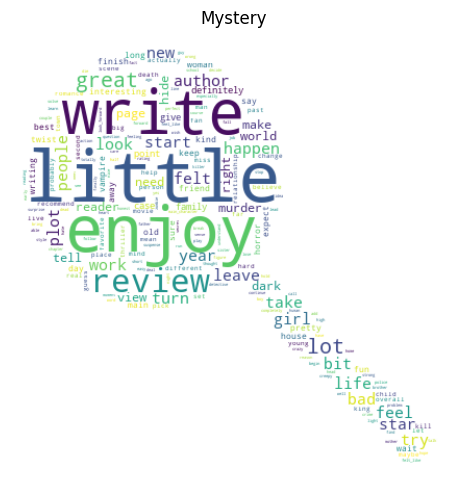

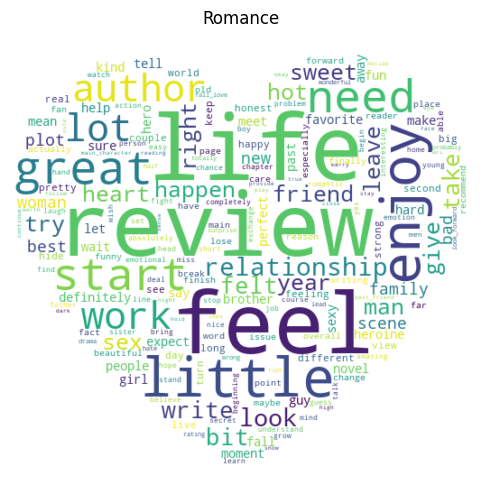

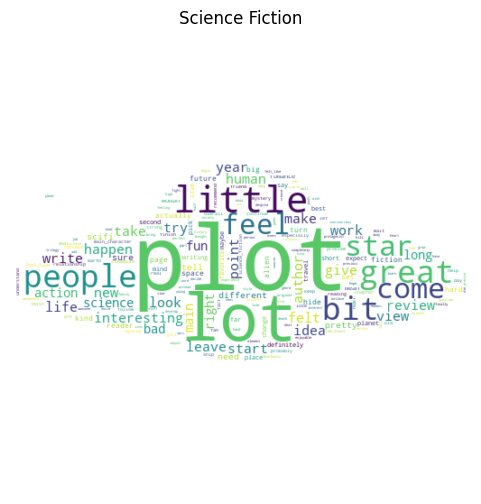

In [125]:
for genre in genre_url.keys():
    generate_wordcloud_genre(rev_df, genre)

# Clustering

## Summarize (managing dimensionality)

In [126]:
!pip install gensim==3.4.0
!pip install sentence-transformers
!pip install bcubed

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 22.2 MB 1.5 MB/s 
  Created wheel for gensim: filename=gensim-3.4.0-cp38-cp38-linux_x86_64.whl size=23477328 sha256=700f6100a2e4ff3dc608f1d94eb46df8b50419414399a0c92ea3ccba741b9cb7
  Stored in directory: /root/.cache/pip/wheels/b4/a4/71/a301cdb2b7d5d31525936fcb8dcd9a5f144578d047407f7cf9
Successfully built gensim
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85 kB 5.8 MB/s 
     |████████████████████████████████| 1.3 MB 55.4 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=292cf3b791986f9a8e625313e5786a2457581439e4f064f07c05af29d75b3b1e
  Stored in directory: /root/.cache/pip/wheels/5e/6f/8c/d88aec621f3f542d26fac0342bef5e693335d125f4e54aeffe
Successfully built sentence-transformers
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from gensim import summarization

summaries = []
for review in tqdm(rev_df['review_text'], desc="Summarization"): # tqdm gives us a nice progress bar
    try:
        summary = summarization.summarize(review, ratio = 0.3, split = True) # summarize the sentences
    except Exception:
        summary = [review] # otherwise keep the full text
    
    if summary == []:
        summary = [review]
    summaries.append(summary)

rev_df['Summary-TextRank'] = summaries

In [ ]:
#define the pooling function to average sentence vectors
def pool(embeddings, method = "mean"):
    poolers = {
                "mean" : lambda x: np.mean(x, axis=0),
                "max"  : lambda x: np.max(x, axis=0),
                "min"  : lambda x: np.min(x, axis=0)
              }   
    return poolers[method](embeddings)

In [ ]:
from sentence_transformers import SentenceTransformer 

model = 'distilbert-base-nli-stsb-mean-tokens'
embedder = SentenceTransformer(model)

## Create Embeddings

In [ ]:
embeddings_TextRank = []
for summary in tqdm(rev_df['Summary-TextRank'], desc="Embedding reviews"):
    sentences_embeddings = embedder.encode(summary) # summary is a list of sentences
    doc_embeddings = pool(sentences_embeddings)
    embeddings_TextRank.append(doc_embeddings)
embeddings_TextRank = np.array(embeddings_TextRank)
embeddings_TextRank.shape

### Trying a Hierarchical Clustering

In [ ]:
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import bcubed

X = pdist(embeddings_TextRank, metric = 'cosine') #1-d condensed distance array (with cosine)
Z = linkage(X, method = 'complete') # generate the linkage matrix

In [ ]:
plt.figure(figsize=(8, 4))
plt.title(f'Hierarchical Clustering - Complete Linkage')
plt.xlabel('branches')
plt.ylabel('distance')
dendrogram(Z, orientation = "top", no_labels = True, truncate_mode='lastp') # draw the dendrogram
plt.show()

## Measuring difference from original Genre Labels

In [ ]:
def eval_BCubed(clusters, ground_truth):    
    predicted = {i: set([str(c)]) for i, c in enumerate(clusters)}
    precision = bcubed.precision(predicted, ground_truth)
    recall = bcubed.recall(predicted, ground_truth)
    fscore = bcubed.fscore(precision, recall)
    return precision, recall, fscore

In [ ]:
categories = pd.factorize(rev_df['genre'])[0] #numerical categories for labels
ground_truth = {i: set([c]) for i, c in enumerate(categories)}

In [ ]:
clusters = fcluster(Z, t = 1.2, criterion = 'distance')
n_clusters = len(set(clusters))

In [149]:
cut = 1.275
clusters = fcluster(Z, t = cut, criterion = 'distance')
n_clusters = len(set(clusters))
precision, recall, fscore = eval_BCubed(clusters, ground_truth)

clust_results = {"Distance": cut,
                 "Clusters": n_clusters,
                 "Precision": round(precision, 2),
                 "Recall": round(recall, 2),
                 "F1 Score": round(fscore, 2)}

In [150]:
clust_results

{'Distance': 1.275,
 'Clusters': 5,
 'Precision': 0.17,
 'Recall': 0.64,
 'F1 Score': 0.27}

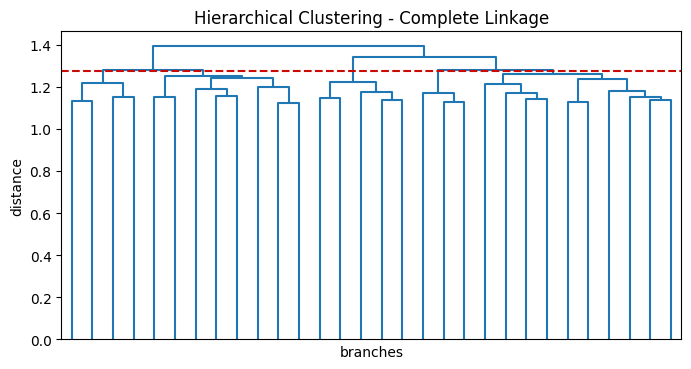

In [151]:
plt.figure(figsize=(8, 4))
plt.title(f'Hierarchical Clustering - Complete Linkage')
plt.xlabel('branches')
plt.ylabel('distance')
plt.axhline(y=1.275, color='r', linestyle='--')
dendrogram(Z, orientation = "top", no_labels = True, truncate_mode='lastp') # draw the dendrogram
plt.show()